In [186]:
pip install NLPWash

In [187]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NLPWash import textscrub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from heapq import nlargest
from collections import defaultdict
import tensorflow as tf
from sentence_transformers import SentenceTransformer, util
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')

In [188]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1.	Process the dataset, tokenize, build features. Do some exploratory data analysis and share the results.**

# **Reading Data**

In [189]:
df = pd.read_excel("/content/drive/MyDrive/MTech/wiki_movie_plots_deduped.xlsx")

In [190]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Unnamed: 8
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",NaN
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",NaN
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",NaN
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,NaN
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,NaN


In [191]:
df.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Unnamed: 8'],
      dtype='object')

In [192]:
df.shape

(34892, 9)

# **Removing column named *Unnamed: 8* and renaming following columns:**


1.   Origin/Ethnicity to Origin
2.   Wiki Page to Wiki_Page
3.   Release Year to Release_year



In [193]:
df = df.drop(columns=['Unnamed: 8'])
column_name_mapping = {
    'Release Year': 'Release_Year',
    'Origin/Ethnicity': 'Origin',
    'Wiki Page': 'Wiki_Page'
}

df = df.rename(columns=column_name_mapping)

In [194]:
df.isnull().sum()

Release_Year       0
Title              2
Origin             2
Director           2
Cast            1424
Genre              2
Wiki_Page          2
Plot               2
dtype: int64

In [195]:
df['Cast'].fillna(value='NA', inplace=True)

rows_to_drop = ['Title', 'Origin', 'Director', 'Genre', 'Wiki_Page', 'Plot']
df = df.dropna(subset=rows_to_drop)

In [196]:
df.isnull().sum()

Release_Year    0
Title           0
Origin          0
Director        0
Cast            0
Genre           0
Wiki_Page       0
Plot            0
dtype: int64

In [197]:
df.head()

,Release_Year,Title,Origin,Director,Cast,Genre,Wiki_Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NA,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NA,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NA,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NA,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NA,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


# **Data Cleaning and Exploratry Data Analysis**

# For column "Origin"

In [198]:
df['Origin'].value_counts()

American                                                                                                                       17377
British                                                                                                                         3670
Bollywood                                                                                                                       2931
Tamil                                                                                                                           2599
Telugu                                                                                                                          1311
Japanese                                                                                                                        1188
Malayalam                                                                                                                       1095
Hong Kong                                                            

Replacing 4 rows with **Not Clear** because **Origin** is not clear and the text is some random line

In [199]:
substring_to_replace1 = " then returns to sever the Lanka King at the waistline. With only his head immortal in comparison with the rest of his body"
substring_to_replace2 = " his long hair is also dirty and out of place and his whole body is covered in wounds"
replacement_value = "NOT CLEAR"

df['Origin'] = df['Origin'].str.replace(substring_to_replace1, replacement_value, case=False, regex=False)
df['Origin'] = df['Origin'].str.replace(substring_to_replace2, replacement_value, case=False, regex=False)


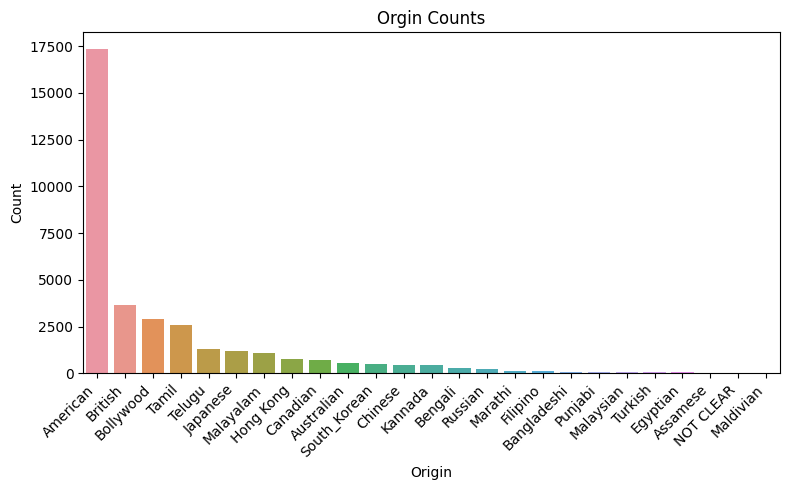

In [200]:
orgin_counts = df['Origin'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=orgin_counts.index, y=orgin_counts.values)
plt.title('Orgin Counts')
plt.xlabel('Origin')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# It is found that most of the movies in the dataset has origin America followed by British, Bollywood and Tamil.

In [201]:
grouped_data = df.groupby(['Release_Year', 'Origin']).size().reset_index(name='Movie Count')

In [202]:
grouped_data.head()

# The grouped data and bar plot provide insights into the distribution of movies across different release years and origins

,Release_Year,Origin,Movie Count
0,1901,American,4
1,1902,American,1
2,1903,American,2
3,1904,American,1
4,1905,American,2


In [203]:
grouped_data['Release_Year'].value_counts()

2014                    22
2017                    21
2015                    21
2013                    21
2011                    21
                        ..
1915                     1
1916                     1
1917                     1
1918                     1
With the battle over     1
Name: Release_Year, Length: 119, dtype: int64

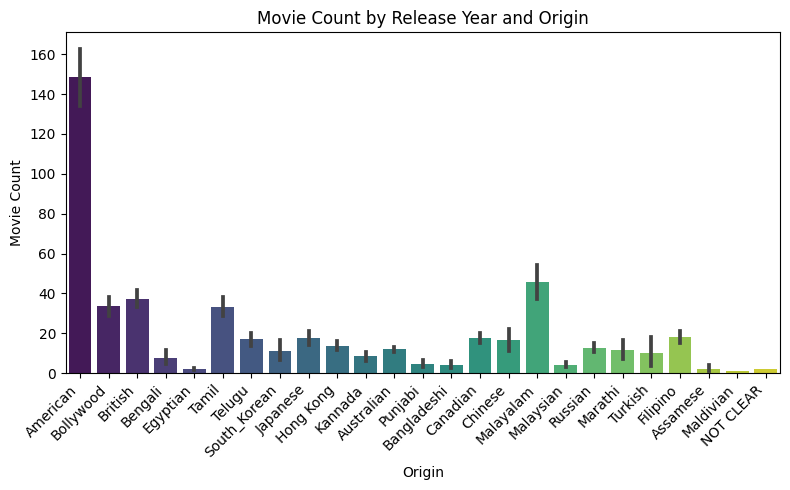

In [204]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Origin', y='Movie Count', data=grouped_data, palette='viridis')
plt.title('Movie Count by Release Year and Origin')
plt.xlabel('Origin')
plt.ylabel('Movie Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# The higher the bar, the greater the number of movies originating from that specific place in the corresponding release year.

# By comparing the heights of bars for different origins, we can observe which origins have a higher or lower number of movie releases in each release year.

# Because there were total release year, it was not feasible to show legends of all release years.

# For Genre

In [205]:
genre_df = df['Genre'].value_counts()

In [206]:
genre_df.shape

(2267,)



1. Building a precise machine learning model for predicting movie genres is tough because there are 2267 different genres.
2. This large number of categories, combined with the fact that many genres have very few examples, makes it hard to create an accurate and dependable model.

Therefore this column needs to be cleaned thoroughly. I have used pivot table in excel to cross check all generes and then tried to replace it with some other string.

For example:
bio-pic, biopic biography, biographical, biodrama, bio-drama, biographic are reduced to **biography**

In [207]:
df['new_genre'] =df['Genre']
df['new_genre']=df['new_genre'].str.strip()
df['new_genre']=df['new_genre'].str.replace(' - ', '|')
df['new_genre']=df['new_genre'].str.replace(' / ', '|')
df['new_genre']=df['new_genre'].str.replace('/', '|')
df['new_genre']=df['new_genre'].str.replace(' & ', '|')
df['new_genre']=df['new_genre'].str.replace(', ', '|')
df['new_genre']=df['new_genre'].str.replace('; ', '|')
df['new_genre']=df['new_genre'].str.replace('bio-pic', 'biography')
df['new_genre']=df['new_genre'].str.replace('biopic', 'biography')
df['new_genre']=df['new_genre'].str.replace('biographical', 'biography')
df['new_genre']=df['new_genre'].str.replace('biodrama', 'biography')
df['new_genre']=df['new_genre'].str.replace('bio-drama', 'biography')
df['new_genre']=df['new_genre'].str.replace('biographic', 'biography')
df['new_genre']=df['new_genre'].str.replace(' \(film genre\)', '')
df['new_genre']=df['new_genre'].str.replace('animated','animation')
df['new_genre']=df['new_genre'].str.replace('anipic', 'biograpphy')
df['new_genre']=df['new_genre'].str.replace('biopic', 'biography')
df['new_genre']=df['new_genre'].str.replace('biographical', 'biography')
df['new_genre']=df['new_genre'].str.replace('biodrama', 'biography')
df['new_genre']=df['new_genre'].str.replace('bio-drama', 'biography')
df['new_genre']=df['new_genre'].str.replace('biographic', 'biography')
df['new_genre']=df['new_genre'].str.replace(' \(film genre\)', '')
df['new_genre']=df['new_genre'].str.replace('animated','animation')
df['new_genre']=df['new_genre'].str.replace('anipic', 'biography')
df['new_genre']=df['new_genre'].str.replace('biographical', 'biography')
df['new_genre']=df['new_genre'].str.replace('biodrama', 'biography')
df['new_genre']=df['new_genre'].str.replace('bio-drama', 'biography')
df['new_genre']=df['new_genre'].str.replace('biographic', 'biography')
df['new_genre']=df['new_genre'].str.replace(' \(film genre\)', '')
df['new_genre']=df['new_genre'].str.replace('animated','animation')
df['new_genre']=df['new_genre'].str.replace('anime','animation')
df['new_genre']=df['new_genre'].str.replace('children\'s','children')
df['new_genre']=df['new_genre'].str.replace('comedey','comedy')
df['new_genre']=df['new_genre'].str.replace('\[not in citation given\]','')
df['new_genre']=df['new_genre'].str.replace(' set 4,000 years ago in the canadian arctic','')
df['new_genre']=df['new_genre'].str.replace('historical','history')
df['new_genre']=df['new_genre'].str.replace('romantic','romance')
df['new_genre']=df['new_genre'].str.replace('3-d','animation')
df['new_genre']=df['new_genre'].str.replace('3d','animation')
df['new_genre']=df['new_genre'].str.replace('viacom 18 motion pictures','')
df['new_genre']=df['new_genre'].str.replace('sci-fi','science_fiction')
df['new_genre']=df['new_genre'].str.replace('ttriller','thriller')
df['new_genre']=df['new_genre'].str.replace('.','')
df['new_genre']=df['new_genre'].str.replace('based on radio serial','')
df['new_genre']=df['new_genre'].str.replace(' on the early years of hitler','')
df['new_genre']=df['new_genre'].str.replace('sci fi','science_fiction')
df['new_genre']=df['new_genre'].str.replace('science fiction','science_fiction')
df['new_genre']=df['new_genre'].str.replace(' (30min)','')
df['new_genre']=df['new_genre'].str.replace('16 mm film','short')
df['new_genre']=df['new_genre'].str.replace('\[140\]','drama')
df['new_genre']=df['new_genre'].str.replace('\[144\]','')
df['new_genre']=df['new_genre'].str.replace(' for ','')
df['new_genre']=df['new_genre'].str.replace('adventures','adventure')
df['new_genre']=df['new_genre'].str.replace('kung fu','martial_arts')
df['new_genre']=df['new_genre'].str.replace('kung-fu','martial_arts')
df['new_genre']=df['new_genre'].str.replace('martial arts','martial_arts')
df['new_genre']=df['new_genre'].str.replace('world war ii','war')
df['new_genre']=df['new_genre'].str.replace('world war i','war')
df['new_genre']=df['new_genre'].str.replace('biography about montreal canadiens star|maurice richard','biography')
df['new_genre']=df['new_genre'].str.replace('bholenath df|cinekorn entertainment','')
df['new_genre']=df['new_genre'].str.replace(' \(volleyball\)','')
df['new_genre']=df['new_genre'].str.replace('spy film','spy')
df['new_genre']=df['new_genre'].str.replace('anthology film','anthology')
df['new_genre']=df['new_genre'].str.replace('biography fim','biography')
df['new_genre']=df['new_genre'].str.replace('avant-garde','avant_garde')
df['new_genre']=df['new_genre'].str.replace('biker film','biker')
df['new_genre']=df['new_genre'].str.replace('buddy cop','buddy')
df['new_genre']=df['new_genre'].str.replace('buddy film','buddy')
df['new_genre']=df['new_genre'].str.replace('comedy 2-reeler','comedy')
df['new_genre']=df['new_genre'].str.replace('films','')
df['new_genre']=df['new_genre'].str.replace('film','')
df['new_genre']=df['new_genre'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
df['new_genre']=df['new_genre'].str.replace('british-german co-production','')
df['new_genre']=df['new_genre'].str.replace('bruceploitation','martial_arts')
df['new_genre']=df['new_genre'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
df['new_genre']=df['new_genre'].str.replace('df by the mob\|knkspl','')
df['new_genre']=df['new_genre'].str.replace('df','')
df['new_genre']=df['new_genre'].str.replace('movie','')
df['new_genre']=df['new_genre'].str.replace('coming of age','coming_of_age')
df['new_genre']=df['new_genre'].str.replace('coming-of-age','coming_of_age')
df['new_genre']=df['new_genre'].str.replace('drama about child soldiers','drama')
df['new_genre']=df['new_genre'].str.replace('(( based).+)','')
df['new_genre']=df['new_genre'].str.replace('(( co-produced).+)','')
df['new_genre']=df['new_genre'].str.replace('(( adapted).+)','')
df['new_genre']=df['new_genre'].str.replace('(( about).+)','')
df['new_genre']=df['new_genre'].str.replace('musical b','musical')
df['new_genre']=df['new_genre'].str.replace('animationchildren','animation|children')
df['new_genre']=df['new_genre'].str.replace(' period','period')
df['new_genre']=df['new_genre'].str.replace('drama loosely','drama')
df['new_genre']=df['new_genre'].str.replace(' \(aquatics|swimming\)','')
df['new_genre']=df['new_genre'].str.replace(' \(aquatics|swimming\)','')
df['new_genre']=df['new_genre'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
df['new_genre']=df['new_genre'].str.replace("war-time","war")
df['new_genre']=df['new_genre'].str.replace("wartime","war")
df['new_genre']=df['new_genre'].str.replace("ww1","war")
df['new_genre']=df['new_genre'].str.replace('unknown','')
df['new_genre']=df['new_genre'].str.replace("wwii","war")
df['new_genre']=df['new_genre'].str.replace('psychological','psycho')
df['new_genre']=df['new_genre'].str.replace('rom-coms','romance')
df['new_genre']=df['new_genre'].str.replace('true crime','crime')
df['new_genre']=df['new_genre'].str.replace('\|007','')
df['new_genre']=df['new_genre'].str.replace('slice of life','slice_of_life')
df['new_genre']=df['new_genre'].str.replace('computer animation','animation')
df['new_genre']=df['new_genre'].str.replace('gun fu','martial_arts')
df['new_genre']=df['new_genre'].str.replace('j-horror','horror')
df['new_genre']=df['new_genre'].str.replace(' \(shogi|chess\)','')
df['new_genre']=df['new_genre'].str.replace('afghan war drama','war drama')
df['new_genre']=df['new_genre'].str.replace('\|6 separate stories','')
df['new_genre']=df['new_genre'].str.replace(' \(30min\)','')
df['new_genre']=df['new_genre'].str.replace(' (road bicycle racing)','')
df['new_genre']=df['new_genre'].str.replace(' v-cinema','')
df['new_genre']=df['new_genre'].str.replace('tv miniseries','tv_miniseries')
df['new_genre']=df['new_genre'].str.replace('\|docudrama','\|documentary|drama')
df['new_genre']=df['new_genre'].str.replace(' in animation','|animation')
df['new_genre']=df['new_genre'].str.replace('((adaptation).+)','')
df['new_genre']=df['new_genre'].str.replace('((adaptated).+)','')
df['new_genre']=df['new_genre'].str.replace('((adapted).+)','')
df['new_genre']=df['new_genre'].str.replace('(( on ).+)','')
df['new_genre']=df['new_genre'].str.replace('american football','sports')
df['new_genre']=df['new_genre'].str.replace('dev\|nusrat jahan','sports')
df['new_genre']=df['new_genre'].str.replace('television miniseries','tv_miniseries')
df['new_genre']=df['new_genre'].str.replace(' \(artistic\)','')
df['new_genre']=df['new_genre'].str.replace(' \|direct-to-dvd','')
df['new_genre']=df['new_genre'].str.replace('history dram','history drama')
df['new_genre']=df['new_genre'].str.replace('martial art','martial_arts')
df['new_genre']=df['new_genre'].str.replace('psycho thriller,','psycho thriller')
df['new_genre']=df['new_genre'].str.replace('\|1 girl\|3 suitors','')
df['new_genre']=df['new_genre'].str.replace(' \(road bicycle racing\)','')
filterE = df['new_genre']=="ero"
df.loc[filterE,'new_genre']="adult"
filterE = df['new_genre']=="music"
df.loc[filterE,'new_genre']="musical"
filterE = df['new_genre']=="-"
df.loc[filterE,'new_genre']=''
filterE = df['new_genre']=="comedy–drama"
df.loc[filterE,'new_genre'] = "comedy|drama"
filterE = df['new_genre']=="comedy–horror"
df.loc[filterE,'new_genre'] = "comedy|horror"
df['new_genre']=df['new_genre'].str.replace(' ','|')
df['new_genre']=df['new_genre'].str.replace(',','|')
df['new_genre']=df['new_genre'].str.replace('-','')
df['new_genre']=df['new_genre'].str.replace('actionadventure','action|adventure')
df['new_genre']=df['new_genre'].str.replace('actioncomedy','action|comedy')
df['new_genre']=df['new_genre'].str.replace('actiondrama','action|drama')
df['new_genre']=df['new_genre'].str.replace('actionlove','action|love')
df['new_genre']=df['new_genre'].str.replace('actionmasala','action|masala')
df['new_genre']=df['new_genre'].str.replace('actionchildren','action|children')

df['new_genre']=df['new_genre'].str.replace('fantasychildren\|','fantasy|children')
df['new_genre']=df['new_genre'].str.replace('fantasycomedy','fantasy|comedy')
df['new_genre']=df['new_genre'].str.replace('fantasyperiod','fantasy|period')
df['new_genre']=df['new_genre'].str.replace('cbctv_miniseries','tv_miniseries')
df['new_genre']=df['new_genre'].str.replace('dramacomedy','drama|comedy')
df['new_genre']=df['new_genre'].str.replace('dramacomedysocial','drama|comedy|social')
df['new_genre']=df['new_genre'].str.replace('dramathriller','drama|thriller')
df['new_genre']=df['new_genre'].str.replace('comedydrama','comedy|drama')
df['new_genre']=df['new_genre'].str.replace('dramathriller','drama|thriller')
df['new_genre']=df['new_genre'].str.replace('comedyhorror','comedy|horror')
df['new_genre']=df['new_genre'].str.replace('sciencefiction','science_fiction')
df['new_genre']=df['new_genre'].str.replace('adventurecomedy','adventure|comedy')
df['new_genre']=df['new_genre'].str.replace('animationdrama','animation|drama')
df['new_genre']=df['new_genre'].str.replace('\|\|','|')
df['new_genre']=df['new_genre'].str.replace('muslim','religious')
df['new_genre']=df['new_genre'].str.replace('thriler','thriller')
df['new_genre']=df['new_genre'].str.replace('crimethriller','crime|thriller')
df['new_genre']=df['new_genre'].str.replace('fantay','fantasy')
df['new_genre']=df['new_genre'].str.replace('actionthriller','action|thriller')
df['new_genre']=df['new_genre'].str.replace('comedysocial','comedy|social')
df['new_genre']=df['new_genre'].str.replace('martialarts','martial_arts')
df['new_genre']=df['new_genre'].str.replace('\|\(children\|poker\|karuta\)','')
df['new_genre']=df['new_genre'].str.replace('epichistory','epic|history')

df['new_genre']=df['new_genre'].str.replace('erotica','adult')
df['new_genre']=df['new_genre'].str.replace('erotic','adult')

df['new_genre']=df['new_genre'].str.replace('((\|produced\|).+)','')
df['new_genre']=df['new_genre'].str.replace('chanbara','chambara')
df['new_genre']=df['new_genre'].str.replace('comedythriller','comedy|thriller')
df['new_genre']=df['new_genre'].str.replace('biblical','religious')
df['new_genre']=df['new_genre'].str.replace('biblical','religious')
df['new_genre']=df['new_genre'].str.replace('colour\|yellow\|productions\|eros\|international','')
df['new_genre']=df['new_genre'].str.replace('\|directtodvd','')
df['new_genre']=df['new_genre'].str.replace('liveaction','live|action')
df['new_genre']=df['new_genre'].str.replace('melodrama','drama')
df['new_genre']=df['new_genre'].str.replace('superheroes','superheroe')
df['new_genre']=df['new_genre'].str.replace('gangsterthriller','gangster|thriller')

df['new_genre']=df['new_genre'].str.replace('heistcomedy','comedy')
df['new_genre']=df['new_genre'].str.replace('heist','action')
df['new_genre']=df['new_genre'].str.replace('historic','history')
df['new_genre']=df['new_genre'].str.replace('historydisaster','history|disaster')
df['new_genre']=df['new_genre'].str.replace('warcomedy','war|comedy')
df['new_genre']=df['new_genre'].str.replace('westerncomedy','western|comedy')
df['new_genre']=df['new_genre'].str.replace('ancientcostume','costume')
df['new_genre']=df['new_genre'].str.replace('computeranimation','animation')
df['new_genre']=df['new_genre'].str.replace('dramatic','drama')
df['new_genre']=df['new_genre'].str.replace('familya','family')
df['new_genre']=df['new_genre'].str.replace('familya','family')
df['new_genre']=df['new_genre'].str.replace('dramedy','drama|comedy')
df['new_genre']=df['new_genre'].str.replace('dramaa','drama')
df['new_genre']=df['new_genre'].str.replace('famil\|','family')

df['new_genre']=df['new_genre'].str.replace('superheroe','superhero')
df['new_genre']=df['new_genre'].str.replace('biogtaphy','biography')
df['new_genre']=df['new_genre'].str.replace('devotionalbiography','devotional|biography')
df['new_genre']=df['new_genre'].str.replace('docufiction','documentary|fiction')

df['new_genre']=df['new_genre'].str.replace('familydrama','family|drama')

df['new_genre']=df['new_genre'].str.replace('espionage','spy')
df['new_genre']=df['new_genre'].str.replace('supeheroes','superhero')
df['new_genre']=df['new_genre'].str.replace('romancefiction','romance|fiction')
df['new_genre']=df['new_genre'].str.replace('horrorthriller','horror|thriller')

df['new_genre']=df['new_genre'].str.replace('suspensethriller','suspense|thriller')
df['new_genre']=df['new_genre'].str.replace('musicaliography','musical|biography')
df['new_genre']=df['new_genre'].str.replace('triller','thriller')

df['new_genre']=df['new_genre'].str.replace('\|\(fiction\)','|fiction')

df['new_genre']=df['new_genre'].str.replace('romanceaction','romance|action')
df['new_genre']=df['new_genre'].str.replace('romancecomedy','romance|comedy')
df['new_genre']=df['new_genre'].str.replace('romancehorror','romance|horror')

df['new_genre']=df['new_genre'].str.replace('romcom','romance|comedy')
df['new_genre']=df['new_genre'].str.replace('rom\|com','romance|comedy')
df['new_genre']=df['new_genre'].str.replace('satirical','satire')

df['new_genre']=df['new_genre'].str.replace('science_fictionchildren','science_fiction|children')
df['new_genre']=df['new_genre'].str.replace('homosexual','adult')
df['new_genre']=df['new_genre'].str.replace('sexual','adult')

df['new_genre']=df['new_genre'].str.replace('mockumentary','documentary')
df['new_genre']=df['new_genre'].str.replace('periodic','period')
df['new_genre']=df['new_genre'].str.replace('romanctic','romantic')
df['new_genre']=df['new_genre'].str.replace('politics','political')
df['new_genre']=df['new_genre'].str.replace('samurai','martial_arts')
df['new_genre']=df['new_genre'].str.replace('tv_miniseries','series')
df['new_genre']=df['new_genre'].str.replace('serial','series')

filterE = df['new_genre']=="musical–comedy"
df.loc[filterE,'new_genre'] = "musical|comedy"

filterE = df['new_genre']=="roman|porno"
df.loc[filterE,'new_genre'] = "adult"


filterE = df['new_genre']=="action—masala"
df.loc[filterE,'new_genre'] = "action|masala"


filterE = df['new_genre']=="horror–thriller"
df.loc[filterE,'new_genre'] = "horror|thriller"

df['new_genre']=df['new_genre'].str.replace('family','children')
df['new_genre']=df['new_genre'].str.replace('martial_arts','action')
df['new_genre']=df['new_genre'].str.replace('horror','thriller')
df['new_genre']=df['new_genre'].str.replace('war','action')
df['new_genre']=df['new_genre'].str.replace('adventure','action')
df['new_genre']=df['new_genre'].str.replace('science_fiction','action')
df['new_genre']=df['new_genre'].str.replace('western','action')
df['new_genre']=df['new_genre'].str.replace('western','action')
df['new_genre']=df['new_genre'].str.replace('noir','black')
df['new_genre']=df['new_genre'].str.replace('spy','action')
df['new_genre']=df['new_genre'].str.replace('superhero','action')
df['new_genre']=df['new_genre'].str.replace('social','')
df['new_genre']=df['new_genre'].str.replace('suspense','action')


filterE = df['new_genre']=="drama|romance|adult|children"
df.loc[filterE,'new_genre'] = "drama|romance|adult"

df['new_genre']=df['new_genre'].str.replace('\|–\|','|')
df['new_genre']=df['new_genre'].str.strip(to_strip='\|')
df['new_genre']=df['new_genre'].str.replace('actionner','action')
df['new_genre']=df['new_genre'].str.strip()

In [208]:
new_genre_df = df['new_genre'].value_counts()

In [209]:
new_genre_df.shape

(1208,)

After cleaning, the number of movies genres decreased to 1208 from 2267



In [210]:
new_genre_df = new_genre_df.reset_index().rename(columns={'index': 'Genre', 'new_genre': 'Count'})

In [211]:
new_genre_df.head(5)

,Genre,Count
0,,6204
1,drama,6107
2,comedy,4411
3,action,3790
4,thriller,2163


*So* the count is mininmized but we still need to work on those rows which has
**|** (Vertical bar) in it.
Fo example There are rows which has data like: **history|action|drama**

So I have created a new column and converted it into list and then took only the 1st element of each list. In above example it will be **history**.

In [212]:
new_genre_df['Genre_split'] = new_genre_df['Genre'].str.split('|').str[0]
new_genre_df.tail(5)

,Genre,Count,Genre_split
1203,lgbtthemed|drama,1,lgbtthemed
1204,fantasy|wuxia,1,fantasy
1205,history|action|drama,1,history
1206,costume|comedy,1,costume
1207,olga|khokhlova|sergey|krapiventsev|oleg|sukach...,1,olga


Just for visualization purpose I am taking only those Genre where cumulative frequency is less than 90%. Because there 1208 genre and it is not feasible to plot all together. At the end genre which has only 1 count or less than 5 will not be used in bar plot using this method

In [213]:
new_genre_df['Frequency'] = new_genre_df['Count']/sum(new_genre_df['Count'])
new_genre_df['CumulativeFrequency'] = new_genre_df['Frequency'].cumsum()


In [214]:
new_genre_df.head()

,Genre,Count,Genre_split,Frequency,CumulativeFrequency
0,,6204,,0.177821,0.177821
1,drama,6107,drama,0.175041,0.352862
2,comedy,4411,comedy,0.126430,0.479291
3,action,3790,action,0.108630,0.587922
4,thriller,2163,thriller,0.061997,0.649918


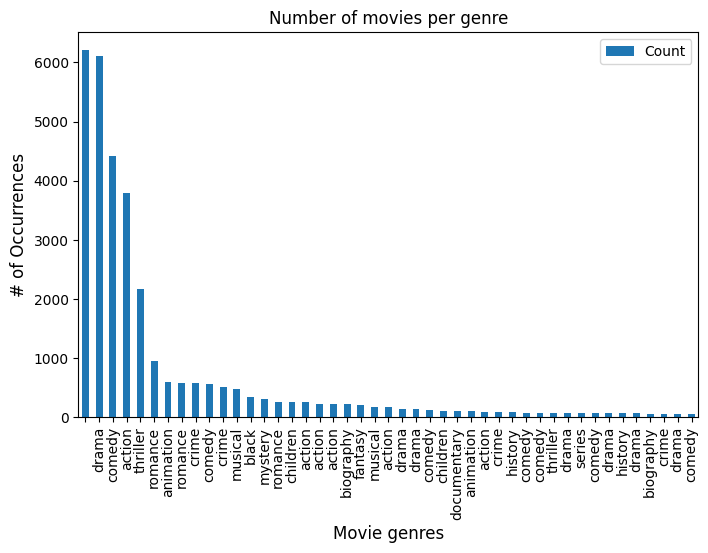

In [215]:
new_genre_df[new_genre_df['CumulativeFrequency']<=.90][['Genre_split','Count']].plot(x='Genre_split', y='Count', kind='bar', figsize=(8, 5))
plt.title("Number of movies per genre")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Movie genres', fontsize=12)
plt.show()

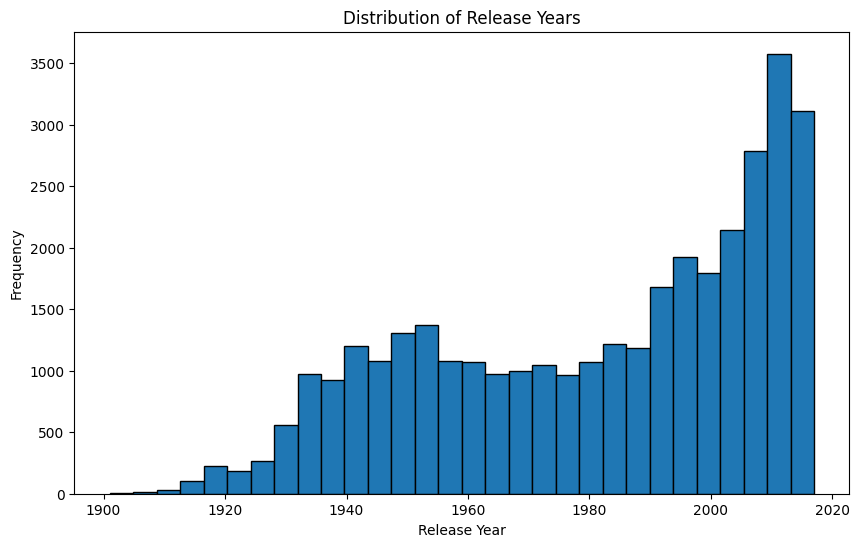

In [235]:
# Plotting the distribution for column Release_year
df['Release_Year'] = pd.to_numeric(df['Release_Year'], errors='coerce')

plt.figure(figsize=(10, 6))
plt.hist(df['Release_Year'].dropna(), bins=30, edgecolor='black')
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Frequency')
plt.show()

# Distribution is left skewed. Most of the movies are released between 2000 to 2010

# **2.	Information retrieval engine (Basic)**

In [216]:
df['Plot'][1]

"The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon's smile gets bigger. They then sit down on a bench by a tree. The moon's view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better."

First I have to clean the plot data to make it ready for ML model.

**I have created my own library called NLPWash, which can be used to clean the data**

Function of NLPWash:
The features of NLPWash is its flexibility. Different projects may have different requirements so I’ve designed the library to allow users to customize with a simple boolean parameter for each pre-processing step.
This level of control enables users to iterate through different configurations, helping them fine-tune the preprocessing process for optimal analysis outcomes.


In [217]:
df['Plot'] = df['Plot'].astype(str)

Below is the use of NLPWash.
It takes just boolean as an input for each preprocessing. Let's say if user wants to keep html tags they just need to set it to False.
When boolean is True it means that it will take necessary step to clean data

In [218]:
plot_clean = textscrub.TextProcessor()

df['normalized_text'] = df['Plot'].apply(plot_clean.normalize_text,
                                        lowercase=True,
                                        tokenization=True,
                                        remove_stopwords=True,
                                        remove_emojis=True,
                                        remove_html_tags = True,
                                        remove_punctuation=True,
                                        remove_hyperlinks= True,
                                        stemming = 'SnowballStemmer',
                                        lemmatizing=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [219]:
df['normalized_text'][1]

'moon paint smile face hang park night young coupl walk past fenc learn rail look moon smile embrac moon smile get bigger sit bench tree moon view block caus frown last scene man fan woman hat moon left sky perch shoulder see everyth better '

In [220]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Transforms the 'Plot' text data into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Plot'])

# Function to get top similar titles for a given input plot
def get_top_similar_titles(input_plot, df, tfidf_vectorizer, tfidf_matrix):

    input_vector = tfidf_vectorizer.transform([input_plot])
    cosine_similarities = linear_kernel(input_vector, tfidf_matrix).flatten()
    top_indices = cosine_similarities.argsort()[:-6:-1] # This line finds the indices of the top 5 most similar movie plots based on their cosine similarity scores.
    top_titles = df['Title'].iloc[top_indices].tolist() # This line retrieves the movie titles corresponding to the top indices and converts them to a Python list

    return top_titles

In [221]:
input_plot = "A few years from now, when society is teetering upon the brink of collapse, berserk motorbike gang member Crawford Nightrider Montazano steals a Pursuit Special, which he uses to escape from police custody "

start_time = time.time()

top_titles = get_top_similar_titles(input_plot, df, tfidf_vectorizer, tfidf_matrix)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")


Execution time: 0.158130 seconds


In [222]:
print("Top 5 similar titles:")
print(top_titles)

Top 5 similar titles:
['Mad Max', 'Fracture', 'From Beyond', 'Cash', "The Brink's Job"]


**3.	Information retrieval engine (Advanced) - Build an efficient ML or DL model using NLP concepts (pre-trained word embeddings, Language models), where if you’re given a short plot description as input, you need to fetch top 5 movie titles whose plot matches the input. Execution time should be a consideration when writing the code. Time and space efficiency will be an important factor during grading.
Hint: You don’t need to search through all the movie plots to fetch top 5.**

In [223]:
df.shape

(34890, 10)

Creating a subset out of the original data

In [224]:
new_df = df[:1000]

In [225]:
new_df.head()

,Release_Year,Title,Origin,Director,Cast,Genre,Wiki_Page,Plot,new_genre,normalized_text
0,1901,Kansas Saloon Smashers,American,Unknown,NA,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr...",,bartend work saloon serv drink custom fill ste...
1,1901,Love by the Light of the Moon,American,Unknown,NA,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov...",,moon paint smile face hang park night young co...
2,1901,The Martyred Presidents,American,Unknown,NA,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed...",,film minut long compos two shot first girl sit...
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NA,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...,,last 61 second consist two shot first shot set...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NA,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...,,earliest known adapt classic fairytal film sho...


In [226]:
pip install sentence-transformers


In [227]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Create embeddings for all movie plots
plot_embeddings = model.encode(new_df['Plot'].astype(str), convert_to_tensor=True)

In [228]:
def get_top_movie_matches(query, plot_embeddings, titles, top_k=5):
    # Encode the query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Calculate cosine similarity between the query and all movie plots
    similarities = util.pytorch_cos_sim(query_embedding, plot_embeddings)[0]

    # Get indices of top-k most similar movies
    top_indices = similarities.argsort(descending=True)[:top_k]

    # Return the top movie titles
    return titles.iloc[top_indices]

In [229]:

# Example usage
query = "The moon, painted with a smiling face hangs over a park at night. A young couple walking past a fence learn on a railing and look up. The moon smiles. They embrace, and the moon\'s smile gets bigger. They then sit down on a bench by a tree. The moon\'s view is blocked, causing him to frown. In the last scene, the man fans the woman with his hat because the moon has left the sky and is perched over her shoulder to see everything better"

start_time = time.time()

top_movies = get_top_movie_matches(query, plot_embeddings, new_df['Title'])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time:.6f} seconds")

Execution time: 0.082125 seconds


In [230]:
print("Top 5 Matching Movies:")
print(top_movies)

Top 5 Matching Movies:
1      Love by the Light of the Moon
916              Dumbbells in Ermine
659    Sunrise: A Song of Two Humans
69                Caught in the Rain
61           The Avenging Conscience
Name: Title, dtype: object
